# OPC/Endothelial Enrichment Analyis from RNA-Seq

In [1]:
import urllib
import os

import pandas
import numpy

%matplotlib inline

## Download data

In [2]:
url_to_path = {
    # Brain RNA-Seq
    'http://web.stanford.edu/group/barres_lab/barreslab_rnaseq.xlsx':
        os.path.join('download', 'barreslab_rnaseq.xlsx'),
}

for url, path in url_to_path.items():
    if not os.path.exists(path):
        urllib.request.urlretrieve(url, path)

## Read GO annotations

In [3]:
url = 'https://github.com/dhimmel/gene-ontology/raw/87bab297f55db283e65a7a984607316b409415ae/annotations/taxid_10090/GO_annotations-10090-inferred-allev.tsv'
go_df = pandas.read_table(url)
go_df.head(2)

,go_id,go_name,go_domain,tax_id,annotation_type,size,gene_ids,gene_symbols
0,GO:0000002,mitochondrial genome maintenance,biological_process,10090,inferred,26,11545|16882|17258|17527|18975|19819|22059|2379...,Parp1|Lig3|Mef2a|Mpv17|Polg|Rnaseh1|Trp53|Akt3...
1,GO:0000003,reproduction,biological_process,10090,inferred,1182,11287|11421|11430|11434|11441|11477|11480|1148...,Pzp|Ace|Acox1|Acr|Chrna7|Acvr1|Acvr2a|Ada|Adam...


## Process expression

In [4]:
path = os.path.join('download', 'barreslab_rnaseq.xlsx')
fpkm_df = pandas.read_excel(path, sheetname='Raw Data')

In [5]:
fpkm_df.head(2)

,Gene symbol,Description,Astrocytes,Neuron,Oligodendrocyte Precursor Cell,Newly Formed Oligodendrocyte,Myelinating Oligodendrocytes,Microglia,Endothelial Cells
0,0610005C13Rik,NaN,0.150958,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
1,0610007C21Rik,NaN,44.891260,34.185493,71.221305,57.985927,54.006096,89.145033,63.561109


In [6]:
# Choose GO IDs to include
go_ids = [
    'GO:0098609', # cell-cell adhesion biological process
    'GO:0009986', #cell surface cellular component
]

go_names = list()

for go_id in go_ids:
    go_genes = go_df.loc[go_df.go_id == go_id, 'gene_symbols'].iloc[0].split('|')
    go_name = go_df.loc[go_df.go_id == go_id, 'go_name'].iloc[0]
    go_names.append(go_name)
    fpkm_df[go_name] = fpkm_df['Gene symbol'].isin(go_genes).astype(int)

# Genes with RNA-Seq data per GO term
fpkm_df[go_names].sum('rows')

cell-cell adhesion    525
cell surface          766
dtype: int64

In [7]:
# Calculate enrichments
fpkm_df['opc_L2FC'] = numpy.log2(fpkm_df['Oligodendrocyte Precursor Cell'] / fpkm_df['Myelinating Oligodendrocytes'])

non_endothelials = ['Astrocytes', 'Neuron', 'Oligodendrocyte Precursor Cell',
                    'Newly Formed Oligodendrocyte', 'Myelinating Oligodendrocytes', 'Microglia']

fpkm_df['endothelial_L2FC'] = numpy.log2(fpkm_df['Endothelial Cells'] / fpkm_df[non_endothelials].mean(axis='columns'))

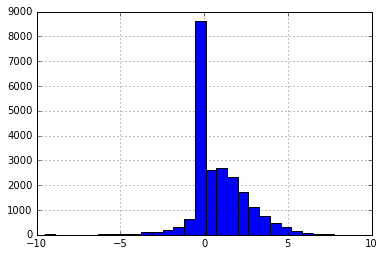

In [8]:
fpkm_df.opc_L2FC.hist(bins=30);

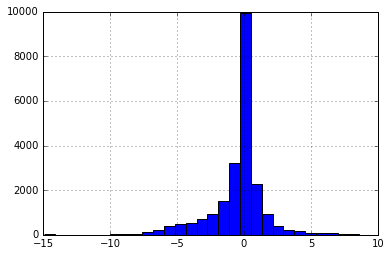

In [9]:
fpkm_df.endothelial_L2FC.hist(bins=30);

## Add dominant active catenin fold change

In [10]:
path = os.path.join('download', 'dominant-active-catenin-DEGs.tsv')
dac_df = pandas.read_table(path, index_col=0)
dac_df['DA_Cat_L2FC'] = numpy.log2(dac_df['Geom mean of intensities in class 1'] / dac_df['Geom mean of intensities in class 2'])
# Convert fold changes from probe to gene space
dac_df = dac_df[['Symbol', 'DA_Cat_L2FC']].groupby('Symbol').mean().reset_index()
dac_df = dac_df.rename(columns={'Symbol': 'Gene symbol'})
dac_df = dac_df.sort_values('DA_Cat_L2FC')
dac_df.head(2)

,Gene symbol,DA_Cat_L2FC
347,Mog,-3.459580
205,Ermn,-2.988046


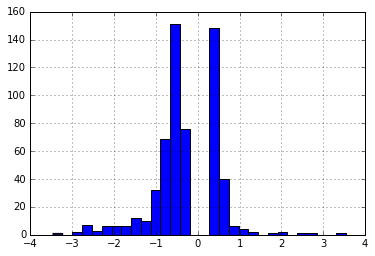

In [11]:
dac_df.DA_Cat_L2FC.hist(bins=30);

In [12]:
fpkm_df = fpkm_df.merge(dac_df, how='left')

## Save dataset

In [13]:
fpkm_df = fpkm_df.sort_values('Gene symbol')
path = os.path.join('data', 'enrichment.tsv')
fpkm_df.to_csv(path, sep='\t', index=False, float_format='%.5g')